In [109]:
import pandas as pd
import numpy as np
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import joblib

In [110]:
df = pd.read_csv('./data/HCC OP+RFA 20230511 n=2261 去名化.csv')
df.head()
len(df)

2261

In [111]:
df = df.drop(df[df['Treatment'] == 2].index)
df.to_csv('./data/HCC OP 20230511 n=2261 去名化.csv',index=False)
len(df)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


1480

In [112]:
selected_features = [
    'OP&RFA Data ID','ISD number','20230511 OP_NAP','Milan_out', 'Age', 'Sex', 'Image_Vasulcar_invasion(Portal vein,Hepatic vein)', 'BCLC', 'Child_Class'
    , 'Weight', 'Height', 'BMI', 'WBC', 'HB', 'PLAT', 'PTINR', 'ALB', 'Na', 'K', 'CHOL','BUN', 'CR', 'BILI','ALK-P','LDH'
    , 'ALT', 'AST', 'APRI','FIB4', 'NLR','GLU','GGT', 'AFP', 'HBsAg', 'HCV'
    , 'alcoholism', 'Tumor size', 'Tumor number', 'ALBIscore', 'ALBIgrade'
]
selected_features_post = ['Histologic grade', 'MVI', 'Inflammation', 'Ishak', 'Steatosis grade']
selected_labels = ['Recur', 'Recurrence free survival','Early recur','Early RFS','Late recur','Late RFS']

In [113]:
df = pd.read_csv('./data/HCC OP 20230511 n=2261 去名化.csv')
df_op = df[ selected_features+selected_labels]
df_op.to_csv('./data/pre_overall/HCC OP survival data.csv',index=False)
print(len(df_op))

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


1480


統計每個欄位的缺值
- ISD number 缺 758
- Late recur,Late RFS 缺 652
- 其他都缺不多，最多的為CHOL:147筆 ,Steatosis grade : 153筆

In [114]:
df_op = pd.read_csv('./data/pre_overall/HCC OP survival data.csv')
nan_counts = df_op.isnull().sum()
result_df = pd.DataFrame({'Column': nan_counts.index, 'NaN_Count': nan_counts.values})
print(result_df)

                                               Column  NaN_Count
0                                      OP&RFA Data ID          0
1                                          ISD number        758
2                                     20230511 OP_NAP        876
3                                           Milan_out          0
4                                                 Age          0
5                                                 Sex          0
6   Image_Vasulcar_invasion(Portal vein,Hepatic vein)          0
7                                                BCLC          0
8                                         Child_Class          0
9                                              Weight         21
10                                             Height         25
11                                                BMI         25
12                                                WBC          0
13                                                 HB          0
14                       

分成三相位齊全跟不齊全的資料集

In [115]:
df = pd.read_csv('./data/pre_overall/HCC OP survival data.csv')
matched_cases = df[df['20230511 OP_NAP'] == 1]['ISD number']

matched_cases_data = df[df['ISD number'].isin(matched_cases)]
matched_cases_data.to_csv('./data/pre_overall/HCC OP 20230511 allNAP.csv',index=False)
print(len(matched_cases),len(matched_cases_data))

604 604


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [116]:
for case in matched_cases:
    df = df.drop(df[df['ISD number'] == case].index)
df.to_csv('./data/pre_overall/HCC OP 20230511 incompleteNAP.csv',index=False)
len(df)

876

統計個案缺值數量
- HCC OP 20230511 allNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']
- HCC OP 20230511 incompleteNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']

In [117]:
df_NAP = pd.read_csv('./data/pre_overall/HCC OP 20230511 allNAP.csv')
df_NAP = df_NAP.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_NAP.isna().T.sum()
df_NAP['Eachcase Nan count'] = num
df_NAP.to_csv('./data/pre_overall/HCC OP 20230511 allNAP_v1.csv',index=False)


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [118]:
column_name = 'Eachcase Nan count'
value_counts = df_NAP[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

   Eachcase Nan count  Percentage
0                 494   81.788079
1                  42    6.953642
2                  39    6.456954
3                  17    2.814570
4                   8    1.324503
5                   4    0.662252


In [119]:
df = pd.read_csv('./data/pre_overall/HCC OP 20230511 allNAP_v1.csv')

# 丟掉 num 欄位數值大於 5 的案例
df_filtered = df[df['Eachcase Nan count'] < 6]
print(len(df_filtered))
df_filtered.to_csv('./data/pre_overall/HCC OP 20230511 allNAP_v1.csv',index=False)

604


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [120]:
df_incomplete = pd.read_csv('./data/pre_overall/HCC OP 20230511 incompleteNAP.csv')
df_incomplete = df_incomplete.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_incomplete.isna().T.sum()
df_incomplete['Eachcase Nan count'] = num
df_incomplete.to_csv('./data/pre_overall/HCC OP 20230511 incompleteNAP_v1.csv',index=False)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [121]:
column_name = 'Eachcase Nan count'
value_counts = df_incomplete[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

   Eachcase Nan count  Percentage
0                 760   86.757991
1                  41    4.680365
2                  38    4.337900
3                  30    3.424658
4                   4    0.456621
5                   3    0.342466


切資料集

In [122]:
df_NAP = pd.read_csv('./data/pre_overall/HCC OP 20230511 allNAP_v1.csv')
df_incomplete = pd.read_csv('./data/pre_overall/HCC OP 20230511 incompleteNAP_v1.csv')

In [123]:
print(len(df_NAP),len(df_incomplete))

604 876


In [124]:
random_num= 321
X = df_NAP.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death = df_NAP['Recur']  # 是否死亡
X_miss = df_incomplete.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death_miss = df_incomplete['Recur']  # 是否死亡

In [125]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_num)
results = sss.split(X, y_death)
train_index, test_index = results.__next__()
results_miss = sss.split(X_miss, y_death_miss)
train_index_miss, test_index_miss = results_miss.__next__()

In [126]:
print(f"Train: {len(train_index)}")
display(df_NAP.iloc[train_index].Recur.value_counts())
print(f"Test: {len(test_index)}")
display(df_NAP.iloc[test_index].Recur.value_counts())
print(f"Train_miss: {len(train_index_miss)}")
display(df_incomplete.iloc[train_index_miss].Recur.value_counts())
print(f"Test_miss: {len(test_index_miss)}")
display(df_incomplete.iloc[test_index_miss].Recur.value_counts())

Train: 422


1    256
0    166
Name: Recur, dtype: int64

Test: 182


1    111
0     71
Name: Recur, dtype: int64

Train_miss: 613


1    323
0    290
Name: Recur, dtype: int64

Test_miss: 263


1    138
0    125
Name: Recur, dtype: int64

In [127]:
train_df = df_NAP.iloc[train_index]
test_df = df_NAP.iloc[test_index]
train_df_miss = df_incomplete.iloc[train_index_miss]
test_df_miss = df_incomplete.iloc[test_index_miss]

In [128]:
train_df = train_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
train_df_miss = train_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df_miss = test_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)

In [129]:
train_df.to_csv("./data/pre_overall/HCC OP 20230511 allNAP_v1_train.csv", index=False)
test_df.to_csv("./data/pre_overall/HCC OP 20230511 allNAP_v1_test.csv", index=False)
train_df_miss.to_csv("./data/pre_overall/HCC OP 20230511 incompleteNAP_v1_train.csv", index=False)
test_df_miss.to_csv("./data/pre_overall/HCC OP 20230511 incompleteNAP_v1_test.csv", index=False)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [130]:
print(len(train_df),len(test_df),len(train_df_miss),len(test_df_miss))

422 182 613 263


HCC OP 20230511 train.csv ,HCC OP 20230511 test.csv是包含recur 跟 early recur兩種

In [131]:
combined_train = pd.concat([train_df, train_df_miss], axis=0)
combined_test = pd.concat([test_df, test_df_miss], axis=0)
combined_train.to_csv('./data/pre_overall/HCC OP 20230511 train.csv',index=False)
combined_test.to_csv('./data/pre_overall/HCC OP 20230511 test.csv',index=False)
print(len(combined_train),len(combined_test))

1035 445


In [132]:
combined_train = combined_train.drop(columns=['Early recur', 'Early RFS'])
combined_test = combined_test.drop(columns=['Early recur', 'Early RFS'])
combined_train.to_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall.csv',index=False)
combined_test.to_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall.csv',index=False)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [133]:
print(len(combined_train),len(combined_test))

1035 445


看資料分布

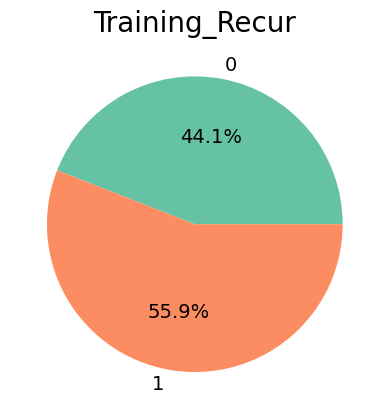

In [134]:
test = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Training_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
#plt.savefig('./data_cluster/統計圖表/train分佈.png')
plt.show()

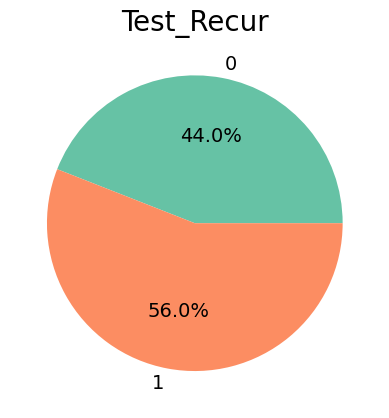

In [135]:
test = pd.read_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Test_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
# plt.savefig('./result/統計圖表/OP_pre test分佈.png')
plt.show()

查看資料集是否有顯著差異

In [136]:
from scipy.stats import ttest_ind
# 計算各欄位的 p-value
p_values = []
for column in combined_train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(combined_train[column], combined_test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(combined_train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

補值

In [137]:
df = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall.csv')
df = df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)

# 初始化 KNNImputer 物件
imputer = KNNImputer(n_neighbors=200)

# 執行 KNN 補值
df_imputed = imputer.fit_transform(df)

# 將補值後的結果轉換為 DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

# 將補值後的結果加入原始資料集中
df = df_imputed
df.to_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input.csv',index=False)
print(len(df))

1035


In [138]:
train_df = pd.read_csv("./data/pre_overall/HCC OP 20230511 train_pre_overall_input.csv")
test_df = pd.read_csv("./data/pre_overall/HCC OP 20230511 test_pre_overall.csv")
test_df = test_df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)
#先將test資料切分出有缺值跟無缺值
known_data = test_df.dropna()
missing_data = test_df[test_df.isna().any(axis=1)]

# 將空字串替換成 NaN 值
#missing_data.replace(' ', np.nan, inplace=True)
missing_data.head()

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,AFP,HBsAg,HCV,alcoholism,Tumor size,Tumor number,ALBIscore,ALBIgrade,Recur,Recurrence free survival
2,1,38.97,1,1,3,1,71.8,168.6,25.258602,6500,...,17661.31,1,0,0.0,4.5,1,-3.045,1.0,1,13.07
6,1,67.03,1,0,1,1,75.4,160.6,29.233463,10500,...,1.04,0,0,0.0,9.5,1,-2.268,2.0,1,12.27
12,1,65.11,2,0,1,1,60.2,165.2,22.058522,7600,...,4853.74,0,0,0.0,11.0,1,-2.135,2.0,1,2.20
16,0,59.00,2,0,1,1,NaN,NaN,NaN,3000,...,20.60,1,0,0.0,4.0,1,-2.820,1.0,1,23.17
26,0,70.95,1,0,1,1,52.4,161.0,20.215269,6500,...,4.72,1,0,1.0,2.2,1,-3.135,1.0,0,66.97


In [139]:
k = 200
imputer = KNNImputer(n_neighbors=k)

for i in range(1,len(missing_data)+1):
    nan_df = missing_data.iloc[i-1:i, :]
    #train_df = pd.concat([train_df,nan_df], ignore_index=True)
    train_df = train_df.append(nan_df)
    
    imputed = imputer.fit_transform(train_df)
    # 進行KNN補值
    df_imputed = pd.DataFrame(imputed, columns=train_df.columns)
    # 提取最後一列資料成為新的 Series 物件
    last_row = df_imputed.iloc[-1,:]
    #known_data = pd.concat([known_data,last_row], ignore_index=True)
    known_data = known_data.append(last_row)
    # 刪除 DataFrame 的最後一列資料
    train_df = train_df.drop(train_df.index[-1])
known_data.to_csv("./data/pre_overall/HCC OP 20230511 test_pre_overall_input.csv",index=False)

C:\Users\Max\AppData\Local\Temp\ipykernel_7348\4184410560.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\Max\AppData\Local\Temp\ipykernel_7348\4184410560.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\Max\AppData\Local\Temp\ipykernel_7348\4184410560.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\Max\AppData\Local\Temp\ipykernel_7348\4184410560.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\Max\AppData\Local\Temp\ipykernel_7348\418

增加衍生特徵

In [140]:
df = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input.csv')
column = 'PLAT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 120000, 0, np.where(df[column] < 150000, 1, 2))
column = 'PTINR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.1, 1, 0)
column = 'ALB'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 3.5, 0, np.where(df[column] < 3.8, 1, 2))
column = 'CR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.2, 1, 0)
column = 'BILI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 1.2, 0, np.where(df[column] < 2, 1, 2))
column = 'ALT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AST'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AFP'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 7, 0,
                               np.where(df[column] < 10, 1,
                                        np.where(df[column] < 20, 2,
                                                 np.where(df[column] < 200, 3, 
                                                          np.where(df[column] < 400, 4,5)))))
column = 'Age'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 50, 0,
                               np.where(df[column] < 60, 1,
                                        np.where(df[column] < 65, 2, 3, 
                                                          )))
column = 'BMI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 23, 0,
                               np.where(df[column] < 25, 1,
                                        np.where(df[column] < 27, 2,
                                                 np.where(df[column] < 27.5, 3, 
                                                          np.where(df[column] < 30, 4,5)))))
column = 'Tumor size'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3, 
                                                          np.where(df[column] < 10, 4,5)))))
column = 'Tumor number'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1, 1, 0)
column = 'NLR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2.5, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3,4))))
column = 'FIB4'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 3.25, 1, 0)


df.to_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features.csv',index=False)

In [141]:
df = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features.csv')
columns_to_ln = ['PLAT', 'BUN', 'CR','ALT','AST','AFP','GGT','CHOL','ALK-P', 'LDH','GLU']

# 對指定欄位進行 ln 轉換並存儲為新欄位
for column in columns_to_ln:
    new_column_name = 'ln' + column
    df[new_column_name] = np.log(df[column])

df.to_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features.csv',index=False)

In [142]:
df = pd.read_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input.csv')
column = 'PLAT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 120000, 0, np.where(df[column] < 150000, 1, 2))
column = 'PTINR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.1, 1, 0)
column = 'ALB'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 3.5, 0, np.where(df[column] < 3.8, 1, 2))
column = 'CR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.2, 1, 0)
column = 'BILI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 1.2, 0, np.where(df[column] < 2, 1, 2))
column = 'ALT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AST'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AFP'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 7, 0,
                               np.where(df[column] < 10, 1,
                                        np.where(df[column] < 20, 2,
                                                 np.where(df[column] < 200, 3, 
                                                          np.where(df[column] < 400, 4,5)))))
column = 'Age'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 50, 0,
                               np.where(df[column] < 60, 1,
                                        np.where(df[column] < 65, 2, 3, 
                                                          )))
column = 'BMI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 23, 0,
                               np.where(df[column] < 25, 1,
                                        np.where(df[column] < 27, 2,
                                                 np.where(df[column] < 27.5, 3, 
                                                          np.where(df[column] < 30, 4,5)))))
column = 'Tumor size'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3, 
                                                          np.where(df[column] < 10, 4,5)))))
column = 'Tumor number'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1, 1, 0)
column = 'NLR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2.5, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3,4))))
column = 'FIB4'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 3.25, 1, 0)


df.to_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features.csv',index=False)

In [143]:
df = pd.read_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features.csv')
columns_to_ln = ['PLAT', 'BUN', 'CR','ALT','AST','AFP','GGT','CHOL','ALK-P', 'LDH','GLU']

# 對指定欄位進行 ln 轉換並存儲為新欄位
for column in columns_to_ln:
    new_column_name = 'ln' + column
    df[new_column_name] = np.log(df[column])

df.to_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features.csv',index=False)

In [144]:
train = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features.csv')
test = pd.read_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features.csv')
p_values = []
for column in train.columns:
    # 執行 t 檢定 
    _, p_value = ttest_ind(train[column], test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

alcoholism


正規化

In [145]:
raw_df = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features.csv')
raw_df_test = pd.read_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features.csv')
display(raw_df.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnBUN,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU
0,0.0,54.97,1.0,0.0,1.0,1.0,62.1,169.5,21.614848,5200.0,...,2.833213,-0.105361,4.442651,4.442651,0.270027,3.218876,5.278115,4.219508,5.236442,4.644391
1,0.0,38.81,1.0,0.0,1.0,1.0,71.0,174.0,23.450918,5600.0,...,2.944439,0.113329,3.806662,3.850148,3.754667,3.713572,5.090278,4.158883,5.447905,4.442651
2,1.0,73.04,1.0,1.0,3.0,1.0,45.9,157.8,18.433113,5700.0,...,2.564949,-0.371064,3.433987,4.043051,1.918392,4.912655,5.140991,4.844187,5.542890,4.677026
3,0.0,65.96,1.0,0.0,1.0,1.0,69.3,170.8,23.755135,5700.0,...,2.772589,0.048790,3.401197,3.367296,1.560248,3.433987,5.293305,4.454347,5.241747,4.521789
4,0.0,48.09,1.0,0.0,1.0,1.0,69.1,168.1,24.453590,4700.0,...,2.772589,0.000000,3.496508,3.465736,1.249902,3.218876,5.010635,4.499810,5.278115,4.406719


In [146]:
X_train = raw_df.drop(columns=['Recur', 'Recurrence free survival'])
y_train = raw_df[['Recur', 'Recurrence free survival']]
X_test = raw_df_test.drop(columns=['Recur', 'Recurrence free survival'])
y_test = raw_df_test[['Recur', 'Recurrence free survival']]

In [147]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
display(scaled_X_train.tail())
display(y_train.tail())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnBUN,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU
1030,-0.848097,-1.160128,-0.54497,-0.229998,-0.124253,-0.108306,1.173034,0.054861,-0.027610,1.845698,...,0.644773,0.150597,0.638773,-0.017756,-0.773565,-0.355940,-1.503501,-1.345677,1.269302,0.713307
1031,1.179110,-1.099080,-0.54497,4.347855,2.866483,-0.108306,3.033962,1.723757,2.040688,-0.536658,...,-0.219820,-0.379410,-1.200753,-0.479758,-0.769768,1.481409,2.321818,1.899095,-1.099077,-0.472709
1032,1.179110,-0.010799,-0.54497,-0.229998,1.371115,-0.108306,0.135374,0.599633,-0.223329,-0.847400,...,-0.219820,-0.278238,2.982456,2.259397,-0.391056,0.924702,-1.387379,0.309133,-0.776772,-0.744757
1033,-0.848097,0.381536,-0.54497,-0.229998,-0.124253,-0.108306,-1.279617,-0.927709,-0.988041,-0.329497,...,1.742609,4.322179,1.455279,0.951589,0.535068,1.512935,-1.464463,-0.628470,0.141192,2.809173
1034,-0.848097,0.313162,-0.54497,-0.229998,-0.124253,-0.108306,-0.353441,0.562977,-0.749979,-0.536658,...,0.158232,0.122065,-0.252649,-0.365764,0.818951,0.317366,0.905118,-0.479230,-0.792775,0.817095


,Recur,Recurrence free survival
1030,0.0,169.30
1031,0.0,60.70
1032,1.0,17.80
1033,1.0,4.10
1034,0.0,3.73


In [148]:
scaled_data = pd.concat([scaled_X_train, y_train], axis=1)
scaled_data_test = pd.concat([scaled_X_test, y_test], axis=1)
scaled_data.to_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features_std.csv',index=False)
scaled_data_test.to_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features_std.csv',index=False)
joblib.dump(scaler, './data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features_scaler.bin')

['./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features_scaler.bin']

確認分布

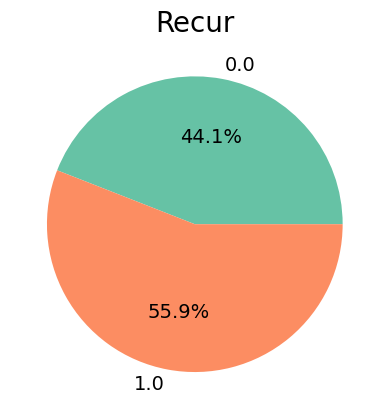

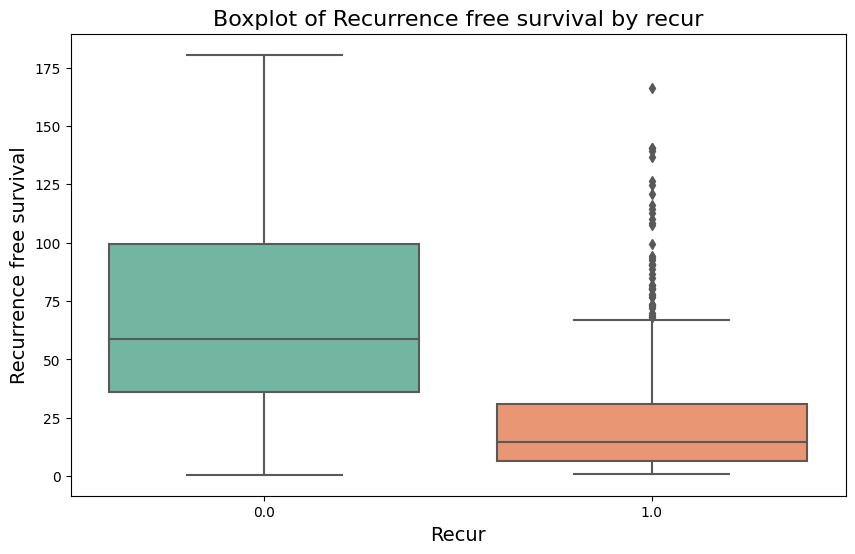

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/pre_overall/HCC OP 20230511 train_pre_overall_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Recurrence free survival']和train['Recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Recur"], y=test["Recurrence free survival"], palette=sns.color_palette("Set2"))
plt.xlabel('Recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()

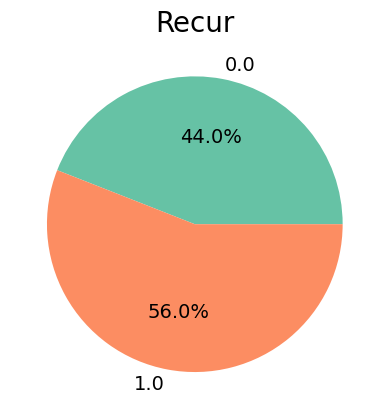

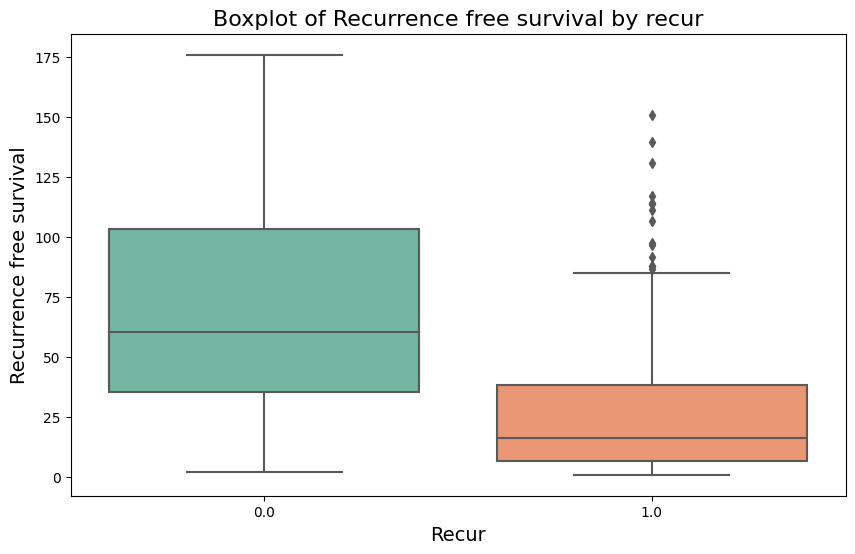

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/pre_overall/HCC OP 20230511 test_pre_overall_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Recurrence free survival']和train['Recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Recur"], y=test["Recurrence free survival"], palette=sns.color_palette("Set2"))
plt.xlabel('Recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()